In [ ]:
import sys
import nltk
nltk.download('wordnet')
# from node import node
from nltk.stem import WordNetLemmatizer
grammar_file = "pcfg.txt"
sentence = "book the flight through Houston".lower().split(' ')

class node:
    def __init__(self, root, left, right, word, score):
        self.root = root
        self.left = left
        self.right = right
        self.word = word
        self.score = score
        self.isEnd = True
        if (word == None):
            self.isEnd = False

grammar = {}
g = [line.rstrip('\n') for line in open(grammar_file)]
lex = {}

# I/O
count = 0
for i in range(len(g)):
    current = g[i].split(' ')
    prob = 0.0
    dic = {}
    iskey = True
    key = ""
    value = []
    if(current[0].isdigit() or current[0][0] == '['):

        if(current[0][0] == '[' ):
            prob = float(current[0][1 : len(current[0]) - 1])
        elif(current[0].isdigit()):
                prob = float(current[0])
        key = current[1]

        if len(current) - 3 <= 2:
            for k in range(3, len(current)):
                value.append(current[k])
        else:
            k = 3
            binary = []
            while True:
                while k < len(current):
                    name = 'X' + str(count)
                    binary.append(current[k])
                    if len(binary) == 2:
                        l = grammar.get(name, [])
                        c = []
                        c.append(binary)
                        c.append(1)
                        l.append(c)
                        grammar[name] = l
                        count = count + 1
                        binary = []
                        value.append(name)
                    if len(binary) < 2 and k == len(current) - 1:
                        value.append(current[k])
                    k = k + 1
                if len(value) <= 2:
                    break
                else:
                    k = 0
                    current = value
                    binary = []
                    value = []
        l = grammar.get(key, [])
        c = []
        c.append(value)
        c.append(prob)
        l.append(c)
        grammar[key] = l
    else:
        for j in range(len(current)):
            if(iskey == True and current[j] != '->'):
                key = current[j]
                iskey = False
            elif(iskey == False and current[j].isalpha()):
                c = current[j]
                j = j + 1
                if(current[j][0] == '['):
                    prob = float(current[j][1 : len(current[j]) - 1])
                elif(current[j].isdigit()):
                    prob = float(current[j])
                value = {}
                value[key] = prob
                if(c not in lex):
                    lex[c] = value
                else:
                    ls = lex[c]
                    ls[key] = prob
                    lex[c] = ls

print(grammar)
# print(lex)

# CKY parsing
cky = [[[] for x in range(len(sentence))] for y in range(len(sentence))]
nodes_back = [[[] for x in range(len(sentence))] for y in range(len(sentence))]

def check_extra(nodes_back, cky, extra, grammar, i, j):
    # Check whether there are other new rules
    while (len(extra) > 0):
        for r in extra:
            for rule in grammar:
                right_list = grammar[rule]
                for detail in right_list:
                    if len(detail[0]) == 1:
                        if r.root == detail[0][0]:
                            cky[i][j].append(rule)

                            for nodes in nodes_back[i][j]:
                                if nodes.root == r.root and nodes.score == r.score:
                                    n = node(rule, None, nodes, None, nodes.score * detail[1])
                                    nodes_back[i][j].append(n)
                                    extra.append(n)
            extra.remove(r)

for i in range(len(sentence)):
    # Find in Lexical
    # Case: A -> word
    word = sentence[i]
    # print(word)
    stem_word = ''
    lexical = ''
    isStem = False
    if word not in lex:
        stemmer = WordNetLemmatizer()
        stem_word = stemmer.lemmatize(word, pos='v')
        print('stem:' + stem_word)
        isStem = True
    if isStem:
        if stem_word not in lex:
            print('The word ' + word + ' is not in the grammar')
            exit()
        else: lexical = lex[stem_word]
    else:
        lexical = lex[word]
    for key in lexical:
        n = node(key, None, None, word, lexical[key])
        nodes_back[i][i].append(n)
        cky[i][i].append(key)

    # Find in grammar
    # Case 1: A -> B (diagonal)
    extra = []
    for rule in grammar:
        right_list = grammar[rule]
        for detail in right_list:
            if len(detail[0]) == 1:
                for r in lexical:
                    if r == detail[0][0]:
                        cky[i][i].append(rule)
                        # map[rule] = lexical[r] * detail[1]

                        for nodes in nodes_back[i][i]:
                            if nodes.root == r:
                                n = node(rule, None, nodes, None, lexical[r] * detail[1])
                                nodes_back[i][i].append(n)
                                extra.append(n)
    check_extra(nodes_back, cky, extra, grammar, i, i)
    # Check whether there are other new rules
    '''
    while(len(extra) > 0):
        for r in extra:
            for rule in grammar:
                right_list = grammar[rule]
                for detail in right_list:
                    if len(detail[0]) == 1:
                        if r == detail[0][0]:
                            map[rule] = map[r] * detail[1]
                            extra.append(rule)
                            for nodes in nodes_back[i][i]:
                                if nodes.root == r:
                                    nodes_back[i][i].append(node(rule, None, nodes, None))
            extra.remove(r)
    '''


    # Find in grammar
    # Case 2: A -> B C
    for j in reversed(range(0, i)):
        # For each block that is not on the diagonal (cky[j][i])
        extra = []
        for k in range(j, i): # cky[j][i] = cky[j][k] + cky[k + 1][i]
            # Search in grammar
            for rule in grammar:
                for derivation in grammar[rule]:
                    if len(derivation[0]) == 2:
                        deri_one = derivation[0][0]
                        deri_two = derivation[0][1]

                        # print(str(j) + " " + str(k))
                        for rule_one in cky[j][k]:
                            for rule_two in cky[k + 1][i]:
                                if rule_one == deri_one and rule_two == deri_two:
                                    cky[j][i].append(rule)

                        for node_one in nodes_back[j][k]:
                            for node_two in nodes_back[k + 1][i]:
                                if node_one.root == deri_one and node_two.root == deri_two:
                                    n = node(rule, node_one, node_two, None, node_one.score * node_two.score * derivation[1])
                                    nodes_back[j][i].append(n)
                                    extra.append(n)
        check_extra(nodes_back, cky, extra, grammar, j, i)

# print the parse tree

def printTree(root):
    if root.isEnd:
        return '[' + root.root + ' ' + root.word + ']'
    left = ''
    right = ''
    if root.left != None:
        left = printTree(root.left)
    if root.right != None:
        right = printTree(root.right)
    return '[' + root.root + ' ' + left + ' ' + right + ']'

terminal_list = nodes_back[0][len(sentence) - 1]
for final_node in terminal_list:
    if(final_node.root == 'S'):
        print('The possibility of this sentence is:' + str(final_node.score))
        print('The parsing result is:' + printTree(final_node))
        flag = True
    if not flag:
        print('No parsing result')

{'S': [[['NP', 'VP'], 0.8], [['XE', 'VP'], 0.1], [['Verb', 'NP'], 0.05], [['VP', 'PP'], 0.03]], 'XE': [[['Aux', 'NP'], 1.0]], 'NP': [[['Det', 'Nominal'], 0.6]], 'Nominal': [[['Nominal', 'Noun'], 0.2], [['Nominal', 'PP'], 0.5]], 'VP': [[['Verb', 'NP'], 0.5], [['VP', 'PP'], 0.3]], 'PP': [[['Preposition', 'NP'], 1.0]]}
The possibility of this sentence is:2.1599999999999996e-05
The parsing result is:[S [Verb book] [NP [Det the] [Nominal [Nominal flight] [PP [Preposition through] [NP houston]]]]]
The possibility of this sentence is:1.296e-05
The parsing result is:[S [VP [Verb book] [NP [Det the] [Nominal flight]]] [PP [Preposition through] [NP houston]]]


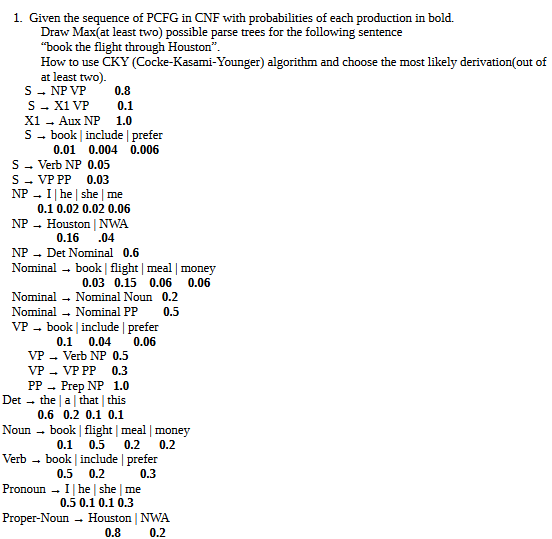

**{'S': [[['NP', 'VP'], 0.8], [['XE', 'VP'], 0.1], [['Verb', 'NP'], 0.05], [['VP', 'PP'], 0.03]], 'XE': [[['Aux', 'NP'], 1.0]], 'NP': [[['Det', 'Nominal'], 0.6]], 'Nominal': [[['Nominal', 'Noun'], 0.2], [['Nominal', 'PP'], 0.5]], 'VP': [[['Verb', 'NP'], 0.5], [['VP', 'PP'], 0.3]], 'PP': [[['Preposition', 'NP'], 1.0]]}**

**The possibility of this sentence is:2.1599999999999996e-05**

**The parsing result is:**
**[S [Verb book] [NP [Det the] [Nominal [Nominal flight] [PP [Preposition through] [NP houston]]]]]**

**The possibility of this sentence is:1.296e-05**

**The parsing result is:**
**[S [VP [Verb book] [NP [Det the] [Nominal flight]]] [PP [Preposition through] [NP houston]]]**
